# Employee Futures Classification with Tensorflow Deep Learning Model


In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Employee.csv")

In [3]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [4]:
df.shape

(4653, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


# EDA

In [6]:
# palette colors
pal = ['#E28F6B','#D1A16D', '76A15A']

In [7]:
def r_color(num=2, seed=None):

    if seed == None:
        seed = np.random.randint(0,420,size=1)
        np.random.seed(seed)


    return [pal[i] for i in np.random.randint(0,5,size=num-1)]

In [8]:
# Add labels to the end of each bar in a bar chart.

def add_value_labels(ax, spacing=5):

    # For each bar: Place a label    
    for rect in ax.patches:
        
        # Get X and Y placement of label from rect.
        x = rect.get_x() + rect.get_width() / 2
        y = rect.get_height()-3

        # Determine vertical alignment for positive and negative values
        va = 'bottom' if y >= 0 else 'top'

        # Format the label to one decimal place
        label = "{}".format(y)

        # Determine the vertical shift of the label
        # based on the sign of the y value and the spacing parameter
        y_shift = spacing * (1 if y >= 0 else -1)

        # Create the annotation
        ax.annotate(label, (x, y), xytext=(0, y_shift),
                    textcoords="offset points", ha='center', va=va)

## Univariate Analysis in Seaborn

In [9]:
def two_plots(feature):
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.title(f'{feature} Histogram')
    ax1 = sns.countplot(data=df, x=feature, palette = r_color(num=1))
    add_value_labels(ax1)
    
    plt.subplot(1,2,2)
    plt.title(f'{feature} by target ')
    ax2 = sns.countplot(data=df, x=feature, hue='LeaveOrNot', palette = r_color())
    add_value_labels(ax2)

    plt.tight_layout()

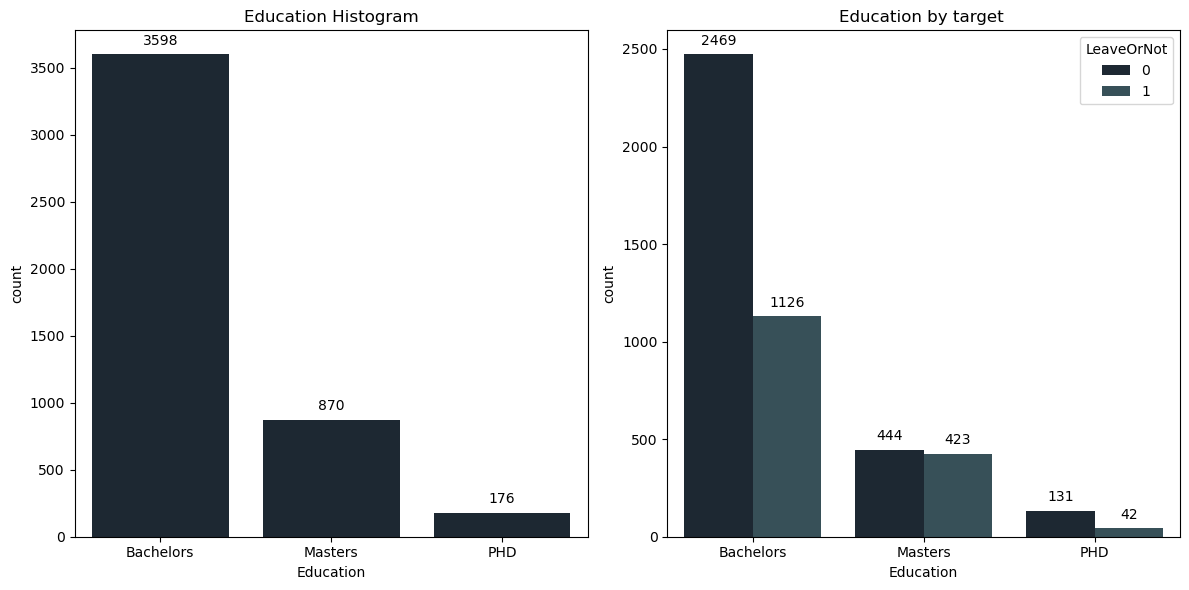

In [10]:
two_plots('Education')

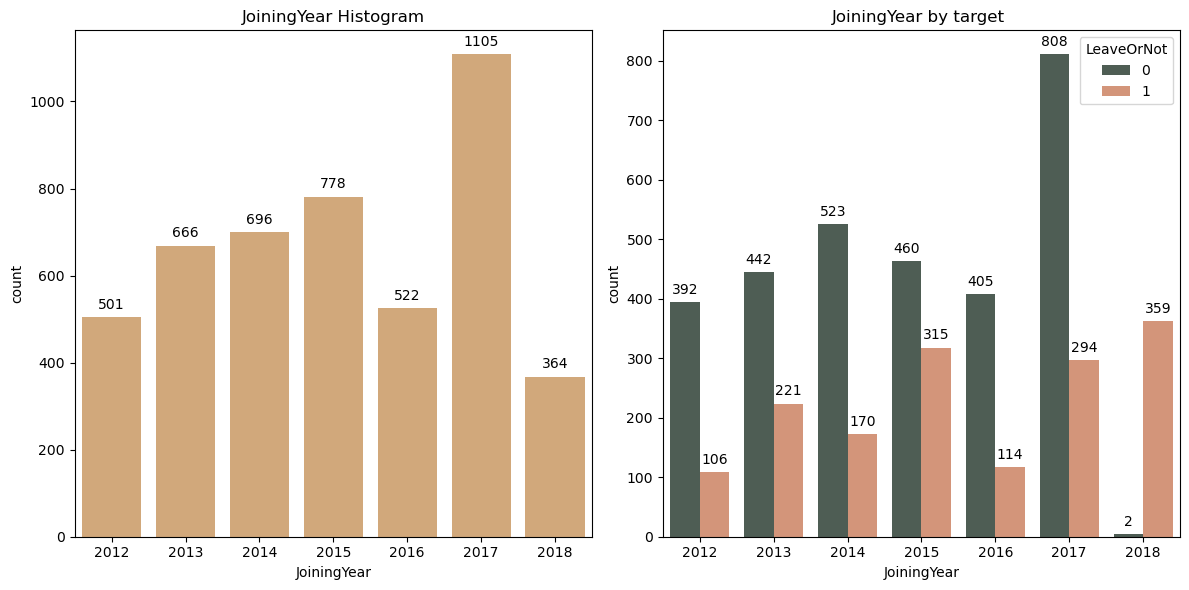

In [11]:
two_plots('JoiningYear')

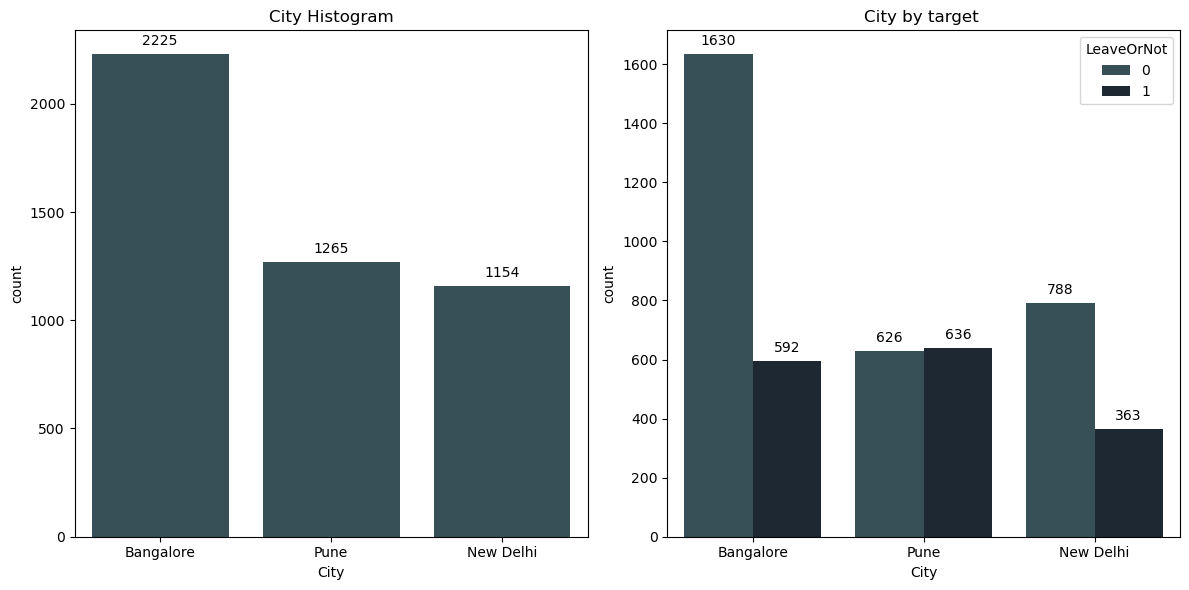

In [19]:
two_plots('City')

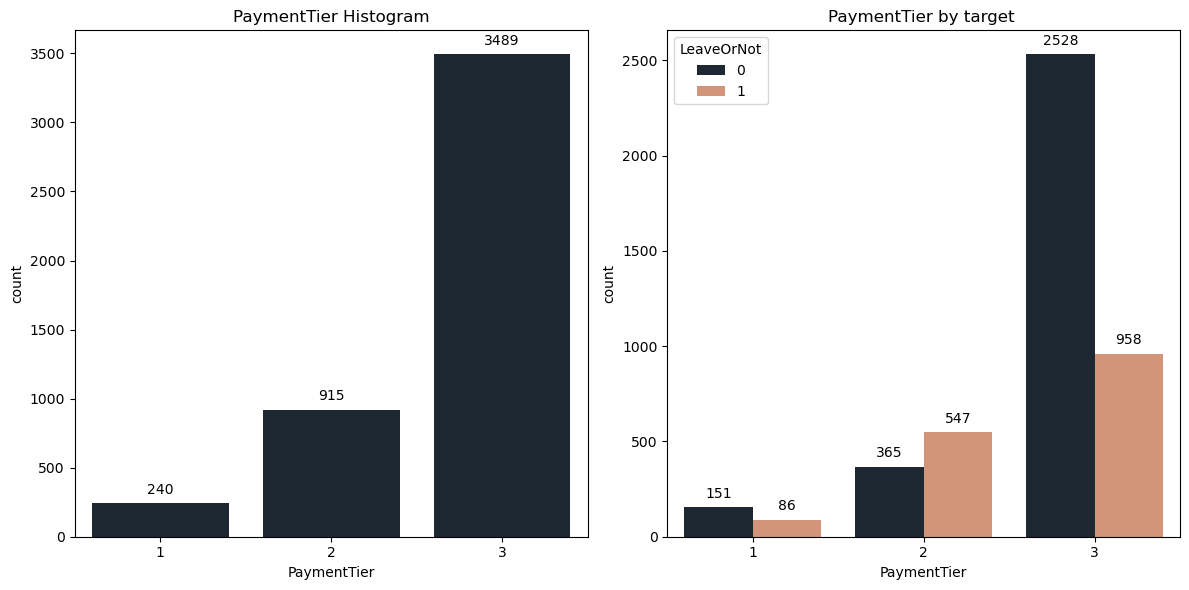

In [13]:
two_plots('PaymentTier')

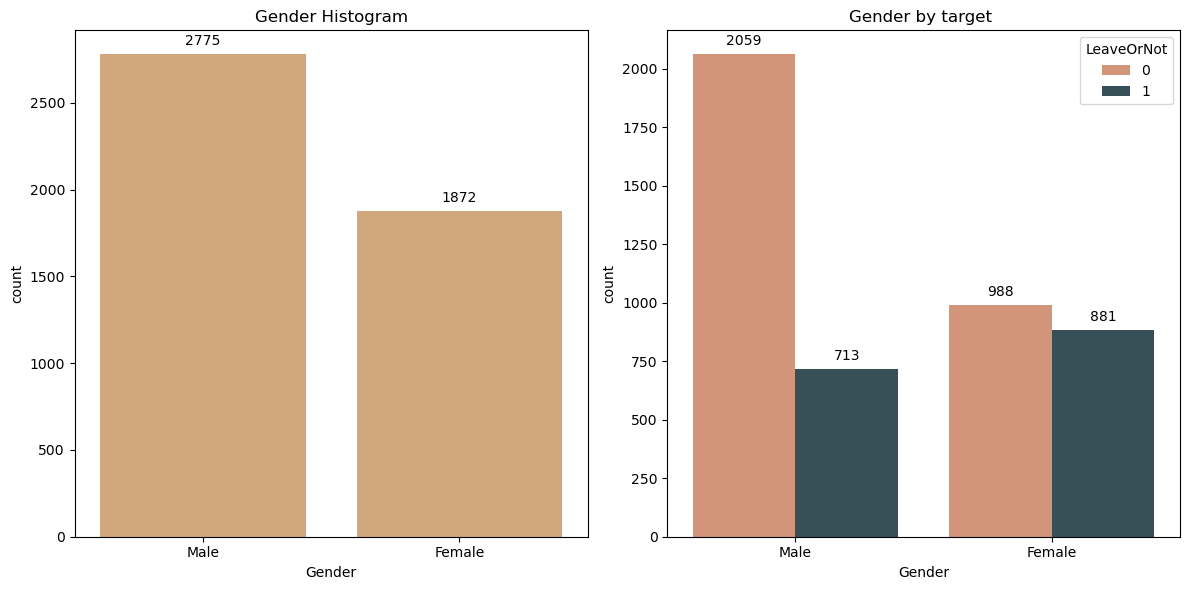

In [20]:
two_plots('Gender')

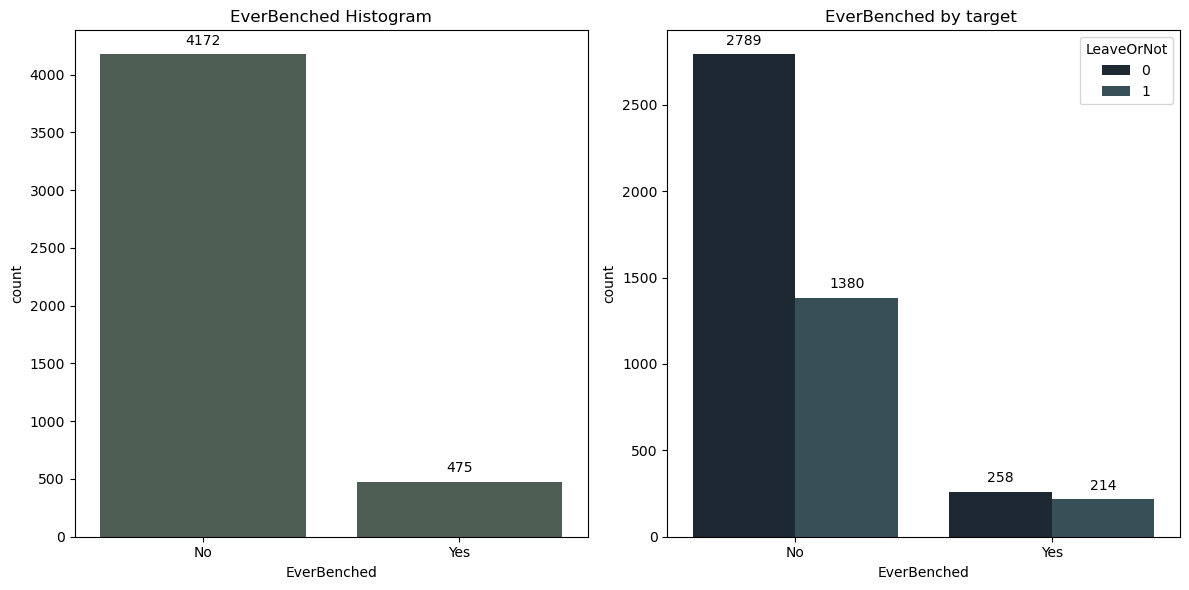

In [15]:
two_plots('EverBenched')

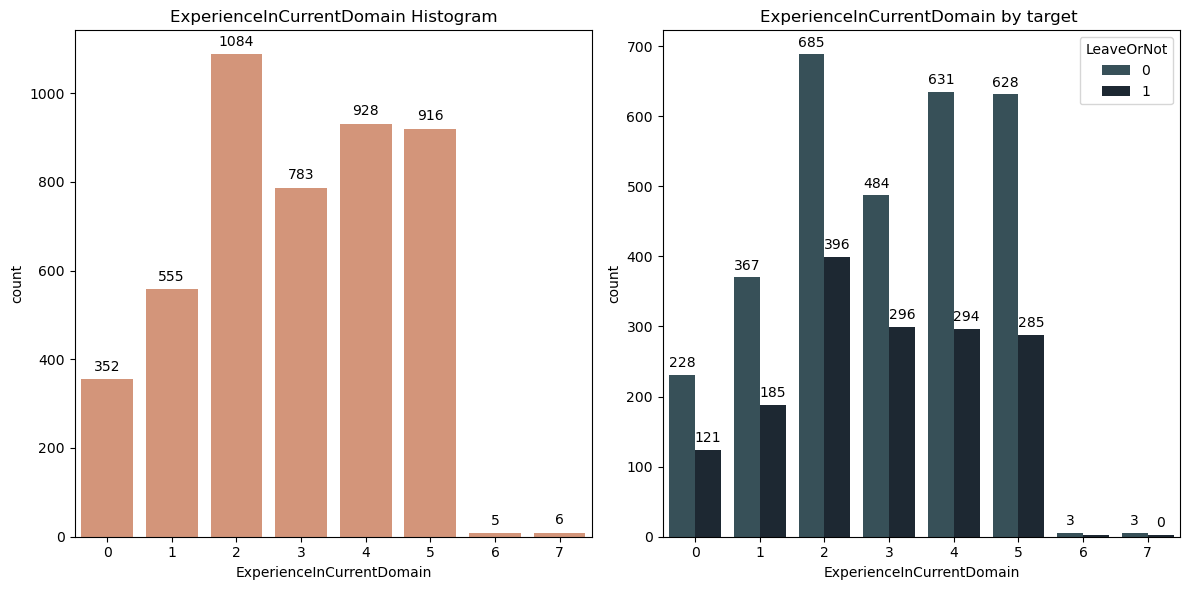

In [16]:
two_plots('ExperienceInCurrentDomain')

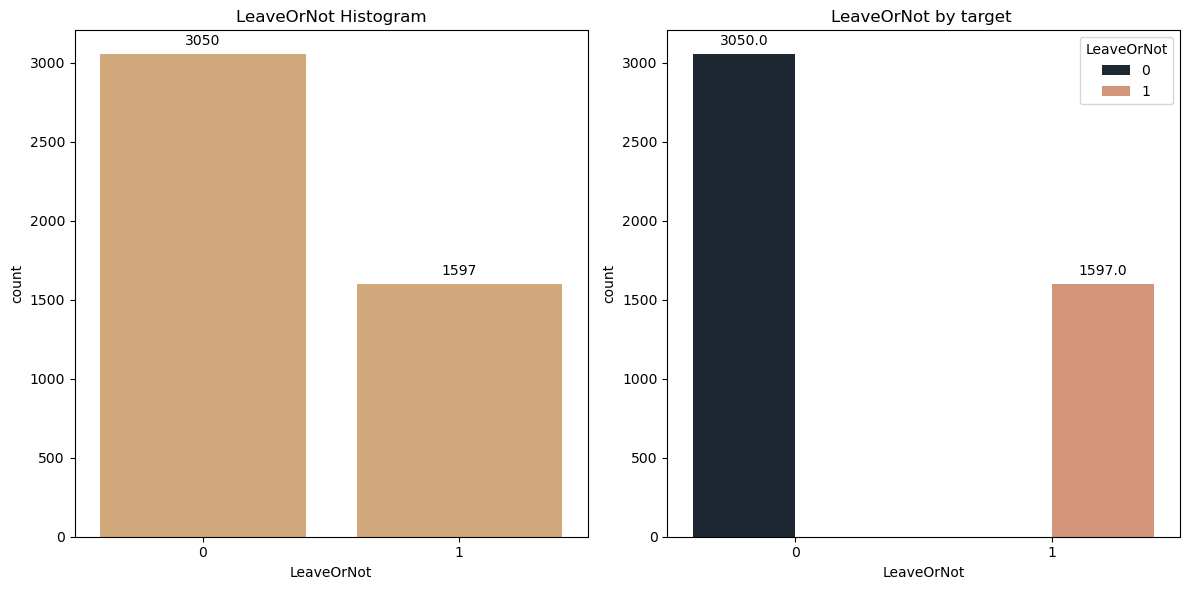

In [17]:
two_plots('LeaveOrNot')

**Observations**

+ Education has 3 categories, bachelor majority, phD small.
+ JoiningYear is semi uniform.
+ City has 3 categories, slight imbalance **one hot**
+ PaymentTier has 3 categories **one hot**
+ Gender has 2 categories, slight imbalance for Male **one hot**
+ Everbenched has 2 categories, large imnbalance **one hot**
+ ExperienceInCurrentDomain has outlier. 


# Preprocessing

## Check null values

In [21]:
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

## One Hot Encoding

In [22]:
df.columns

Index(['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain', 'LeaveOrNot'],
      dtype='object')

In [23]:
labelencoder = LabelEncoder()
for binary_col in ['Gender', 'EverBenched']:
    df[binary_col] = labelencoder.fit_transform(df[binary_col])

In [28]:
ohe_cols = ['Education', 'JoiningYear', 'City']

for col in ohe_cols:
    dumm = pd.get_dummies(df[col], prefix = col, dtype=int, drop_first=True)
    del df[col]
    df = pd.concat([df,dumm], axis=1)

In [29]:
df.columns

Index(['PaymentTier', 'Age', 'Gender', 'EverBenched',
       'ExperienceInCurrentDomain', 'LeaveOrNot', 'Education_Masters',
       'Education_PHD', 'JoiningYear_2013', 'JoiningYear_2014',
       'JoiningYear_2015', 'JoiningYear_2016', 'JoiningYear_2017',
       'JoiningYear_2018', 'City_New Delhi', 'City_Pune'],
      dtype='object')

In [30]:
df.head()

,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,Education_Masters,Education_PHD,JoiningYear_2013,JoiningYear_2014,JoiningYear_2015,JoiningYear_2016,JoiningYear_2017,JoiningYear_2018,City_New Delhi,City_Pune
0,3,34,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,28,0,0,3,1,0,0,1,0,0,0,0,0,0,1
2,3,38,0,0,2,0,0,0,0,1,0,0,0,0,1,0
3,3,27,1,0,5,1,1,0,0,0,0,1,0,0,0,0
4,3,24,1,1,2,1,1,0,0,0,0,0,1,0,0,1


# Modeling

## Train Test Split

In [31]:
target = [ 'LeaveOrNot']
X =  df.drop(columns=target)
y = df[target]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [64]:
def get_scores(model):
    
    model.fit(X_test, y_test) 
    
    y_pred_tr = model.predict(X_train)
    y_pred_ts = model.predict(X_test)
    
    mae_tr = mean_absolute_error(y_train, y_pred_tr)
    mae_ts = mean_absolute_error(y_test, y_pred_ts)
    
    score_tr = model.score(X_train, y_train)
    score_ts = model.score(X_test, y_test)
    
    return {'mea_train':round(mae_tr,3), 'mea_test':round(mae_ts,3), 'train_score':round(score_tr,3), 'test_score':round(score_ts,3)}

In [68]:
rf = RandomForestClassifier(random_state=42)
rf_score = get_scores(rf)
rf_score

{'mea_train': 0.184,
 'mea_test': 0.049,
 'train_score': 0.816,
 'test_score': 0.951}

In [69]:
gb = GradientBoostingClassifier(random_state=42)
gb_score = get_scores(gb)
gb_score

{'mea_train': 0.163,
 'mea_test': 0.12,
 'train_score': 0.837,
 'test_score': 0.88}

In [70]:
log = LogisticRegressionCV()
log_score = get_scores(log)
log_score

{'mea_train': 0.216,
 'mea_test': 0.181,
 'train_score': 0.784,
 'test_score': 0.819}

In [71]:
dict_scores = {'RandomForest':rf_score,
               'GradientBoost':gb_score,
               'Logistic':log_score}

pd.DataFrame(dict_scores)

,RandomForest,GradientBoost,Logistic
mea_train,0.184,0.163,0.216
mea_test,0.049,0.120,0.181
train_score,0.816,0.837,0.784
test_score,0.951,0.880,0.819
